# Problem Set 5
### by Daniel Tracht, February 2019

## Problem 1

In this problem, we will be using the same data on incomes of graduates from the MACSS program as in the previous data set.  We will also be using the log normal distribution as before.

### Part a

We want to plot a histogram of the income data:

In [3]:
# Import the necessary libraries
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
#from mpl_toolkits.mplot3d import Axes3D
#from matplotlib import cm
#cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook

import requests
from IPython.display import Image

# Download and save the data file incomes.txt
url = ('https://raw.githubusercontent.com/dtracht/persp-model-econ_W19/' +
       'master/ProblemSets/PS5/data/incomes.txt')
data_file = requests.get(url, allow_redirects=True)
open('data/incomes.txt', 'wb').write(data_file.content)

# Load the data as a NumPy array
pts = np.loadtxt('data/incomes.txt')

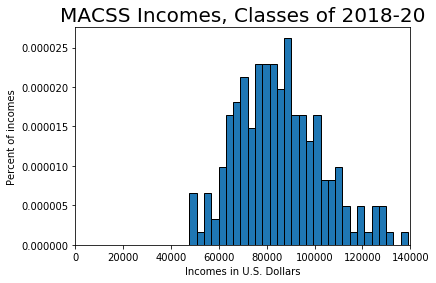

In [6]:
import matplotlib.pyplot as plt

num_bins = 30
# normed option has been deprecated
# using density=True instead
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title("MACSS Incomes, Classes of 2018-20", fontsize=20)
plt.xlabel("Incomes in U.S. Dollars")
plt.ylabel("Percent of incomes")
plt.xlim([0,140000])
plt.show()

### Part b
We want to estimate the parameters of the log normal distribution through  generalized method of moments estimation.  We will use the average income and standard deviation of income as our two moments.  We will use the identity matrix as our weighting matrix.

In [37]:
# takes vector of x values, parameters for mu and sigma
# returns vector of pdf values for the lognormal
from scipy.stats import lognorm
def lognormal_pdf (xvals, mu, sigma):
    pdf_vals = (1 / (xvals * sigma * np.sqrt(2 * np.pi))) * np.exp (-(np.log(xvals)-mu)**2 / (2 * sigma**2))
    #take pdf values that are rounded to zero and reset them to very low
    #pdf_zero = pdf_vals==0
    #pdf_vals[pdf_zero] = 1e-16
    return pdf_vals

def data_moments(xvals):
    mean_data = xvals.mean()
    var_data = xvals.var()
    return mean_data, var_data

def model_moments(mu, sigma):
    xfx = lambda x: x * lognormal_pdf(x, mu, sigma)
    # integrating over to 3 orders more than the upper bound of the data
    (mean_model, m_m_err) = intgr.quad(xfx, 1e-10, 1.4e8)
    x2fx = lambda x: ((x - mean_model) ** 2) * lognormal_pdf(x, mu, sigma) 
    (var_model, v_m_err) = intgr.quad(x2fx, 1e-10, 1.4e8)
    return mean_model, var_model

def err_vec(xvals, mu, sigma, simple):
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec

def criterion(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma, simple=False)
    crit_val = err.T @ W @ err
    return crit_val

In [100]:
import scipy.optimize as opt

# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat1 = np.eye(2)
gmm_args = (pts, W_hat1)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

mu_GMM1= 11.331880928760944  sig_GMM1= 0.20869663980785672


We wish to plot the estimated lognormal PDF against the histogram in part a:

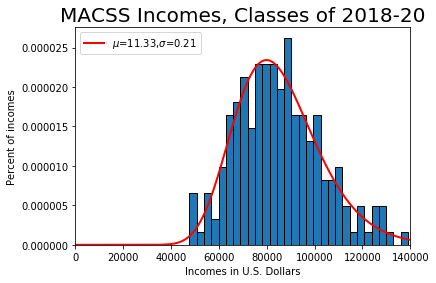

In [39]:
# Plot histogram with the estimated PDF
num_bins = 30
# normed option has been deprecated
# using density=True instead
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title("MACSS Incomes, Classes of 2018-20", fontsize=20)
plt.xlabel("Incomes in U.S. Dollars")
plt.ylabel("Percent of incomes")
plt.xlim([0,140000])


dist_pts = np.linspace(1e-10, 140000, 1000)
plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_GMM1, sig_GMM1),
         linewidth=2, color='r', label='$\mu$=11.33,$\sigma$=0.21')
plt.legend(loc='upper left')

plt.show()

We want the value of the criterion function at the estimated GMM parameters.  We also want to compare the data moments to the model moments at the estimated parameter values:

In [101]:
mean_data, var_data = data_moments(pts)
mean_model, var_model = model_moments(mu_GMM1, sig_GMM1)
err1 = err_vec(pts, mu_GMM1, sig_GMM1, False).reshape(2,)
crit_val = err1.T @ W_hat1 @ err1
print('Mean of points =', mean_data, ', Variance of points =', var_data)
print('Mean of model =', mean_model, ', Variance of model =', var_model)
print('Error vector=', err1)
print("Criterion value at estimated parameters=", crit_val)

Mean of points = 85276.82360625811 , Variance of points = 323731572.2295289
Mean of model = 85276.83046522719 , Variance of model = 323731555.17099494
Error vector= [ 8.04318077e-08 -5.26934517e-08]
Criterion value at estimated parameters= 9.24587554357195e-15


### Part c
We wish to perform a two-step GMM procedure by using the estimates from above to generate an estimator for the variance covariance matrix
$$
\hat{{\Omega}}_{2step}
$$
which we then use to get the optimal weighting matrix
$$
\hat{W}_{2step}:
$$

In [102]:
def get_Err_mat2(pts, mu, sigma, simple=False):
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, var_model = model_moments(mu, sigma)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - var_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - var_model) / var_model
    return Err_mat

In [103]:
# starting with the results above
Err_mat = get_Err_mat2(pts, mu_GMM1, sig_GMM1, False)
VCV2 = (1 / pts.shape[0]) * (Err_mat @ Err_mat.T)
print(VCV2)
W_hat2 = lin.inv(VCV2)
print(W_hat2)

[[0.0445167  0.09358616]
 [0.09358616 1.94756682]]
[[24.98774562 -1.20073267]
 [-1.20073267  0.57115984]]


In [104]:
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (pts, W_hat2)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mu_GMM2= 11.331880928760944  sig_GMM2= 0.20869663980785672


As expected, the point estimates of the parameters are the same as above.  We wish to see the value of the criterion function at the estimated parameters, as well as compare the data moments to the model moments at the generated parameter:

In [44]:
mean_data, var_data = data_moments(pts)
mean_model, var_model = model_moments(mu_GMM2, sig_GMM2)
err2 = err_vec(pts, mu_GMM2, sig_GMM2, False).reshape(2,)
crit_val = err2.T @ W_hat2 @ err2
print('Mean of points =', mean_data, ', Variance of points =', var_data)
print('Mean of model =', mean_model, ', Variance of model =', var_model)
print('Error vector=', err2)
print("Criterion value at estimated parameters=", crit_val)

Mean of points = 85276.82360625811 , Variance of points = 323731572.2295289
Mean of model = 85276.83046522719 , Variance of model = 323731555.17099494
Error vector= [ 8.04318077e-08 -5.26934517e-08]
Criterion value at estimated parameters= 1.7341645910524636e-13


We also want to plot the PDF of the lognormal distribution for the estimated parameters as well as the histogram of the actual data and the PDF of the lognormal distribution from part b:

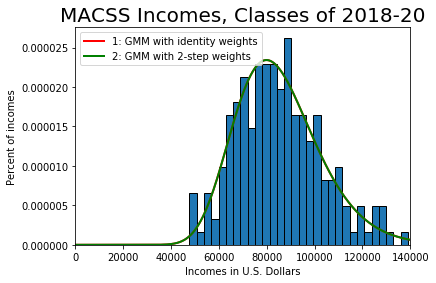

In [45]:
# Plot histogram with the estimated PDF
num_bins = 30
# normed option has been deprecated
# using density=True instead
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title("MACSS Incomes, Classes of 2018-20", fontsize=20)
plt.xlabel("Incomes in U.S. Dollars")
plt.ylabel("Percent of incomes")
plt.xlim([0,140000])


dist_pts = np.linspace(1e-10, 140000, 1000)
plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_GMM1, sig_GMM1),
         linewidth=2, color='r', label='1: GMM with identity weights')
plt.legend(loc='upper left')

plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_GMM2, sig_GMM2),
         linewidth=2, color='g', label='2: GMM with 2-step weights')
plt.legend(loc='upper left')


plt.show()

### Part d
We wish to estimate the lognormal PDF to fit the data using GMM on different moments.  In this part, we will use the percents of indviduals earning less than 75,000 dollars, between 75 and 100 thousand dollars, and more than 100 thousand dollars:

In [83]:
def data_moments3(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 1.2e5)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 1.2e5].shape[0] / xvals.shape[0]
    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def model_moments3(mu, sigma):
    fx = lambda x: lognormal_pdf(x, mu, sigma)
    # lower bound near 0
    # upper bound 3 orders higher than top of data
    (bpct_1_mod, bp_1_err) = intgr.quad(fx, 1e-10, 7.5e4)
    (bpct_2_mod, bp_2_err) = intgr.quad(fx, 7.5e4, 1.2e5)
    (bpct_3_mod, bp_3_err) = intgr.quad(fx, 1.2e5, 1.4e8)
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

def err_vec3(xvals, mu, sigma, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec

def criterion3(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec3(xvals, mu, sigma, simple=False)
    crit_val = err.T @ W @ err 
    return crit_val

In [84]:
# starting at parameters from above
mu_init = 11
sig_init = 0.5
params_init_3 = np.array([mu_init, sig_init])
W_hat1_3 = np.eye(3)
gmm_args_3 = (pts, W_hat1_3)
results_3 = opt.minimize(criterion3, params_init_3, args=(gmm_args_3),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_3, sig_GMM1_3 = results_3.x
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)

mu_GMM1_3= 11.33886315402999  sig_GMM1_3= 0.21666600644065456


We wish to see the value of the criterion function at the estimated parameters, as well as compare the data moments to the model moments at the generated parameters:

In [85]:
bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(pts)
bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu_GMM1_3, sig_GMM1_3)
err1_3 = err_vec3(pts, mu_GMM1_3, sig_GMM1_3, False).reshape(3,)
crit_val_3 = err1_3.T @ W_hat1_3 @ err1_3
print('Percent lower than 75k in data =', bpct_1_dat, ', in model =', bpct_1_mod)
print('Percent between 75k and 100k in data =', bpct_2_dat, ', in model =', bpct_2_mod)
print('Percent above 100k in data =', bpct_3_dat, ', in model =', bpct_3_mod)
print('Error vector=', err1_3)
print("Criterion value at estimated parameters=", crit_val_3)

Percent lower than 75k in data = 0.3 , in model = 0.3000000053796349
Percent between 75k and 100k in data = 0.65 , in model = 0.649999995193099
Percent above 100k in data = 0.05 , in model = 0.04999999942726667
Error vector= [ 1.79321163e-08 -7.39523229e-09 -1.14546667e-08]
Criterion value at estimated parameters= 5.074596455991511e-16


We also want to plot the PDF of the lognormal distribution for the estimated parameters as well as the histogram of the actual data:

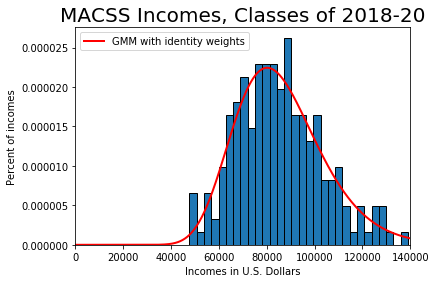

In [86]:
# Plot histogram with the estimated PDF
num_bins = 30
# normed option has been deprecated
# using density=True instead
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title("MACSS Incomes, Classes of 2018-20", fontsize=20)
plt.xlabel("Incomes in U.S. Dollars")
plt.ylabel("Percent of incomes")
plt.xlim([0,140000])


dist_pts = np.linspace(1e-10, 140000, 1000)
plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3),
         linewidth=2, color='r', label='GMM with identity weights')
plt.legend(loc='upper left')

plt.show()

### Part e
We wish to perform a two-step GMM procedure by using the estimates from above to generate an estimator for the variance covariance matrix
$$
\hat{{\Omega}}_{2step}
$$
which we then use to get the optimal weighting matrix
$$
\hat{W}_{2step}
$$
for our three moments

In [87]:
def get_Err_mat3(pts, mu, sigma, simple=False):
    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = model_moments3(mu, sigma)
    if simple:
        pts_in_grp1 = pts < 7.5e4
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 7.5e4) & (pts < 1e5)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts >= 1e5
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod
    else:
        pts_in_grp1 = pts < 7.5e4
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 7.5e4) & (pts < 1e5)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts >= 1e5
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    return Err_mat

In [88]:
Err_mat3 = get_Err_mat3(pts, mu_GMM1_3, sig_GMM1_3, True)
VCV2_3 = (1 / pts.shape[0]) * (Err_mat3 @ Err_mat3.T)
# using the pseudoinverse here
W_hat2_3 = lin.pinv(VCV2_3)

In [93]:
params_init = np.array([mu_GMM1_3, sig_GMM1_3])
gmm_args = (pts, W_hat2_3)
results2_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                          method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2_3, sig_GMM2_3 = results2_3.x
print('mu_GMM2_3=', mu_GMM2_3, ' sig_GMM2_3=', sig_GMM2_3)

mu_GMM2_3= 11.33886315402999  sig_GMM2_3= 0.21666600644065456


We wish to see the value of the criterion function at the estimated parameters, as well as compare the data moments to the model moments at the generated parameters:

In [90]:
bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(pts)
bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu_GMM2_3, sig_GMM2_3)
err2_3 = err_vec3(pts, mu_GMM2_3, sig_GMM2_3, False).reshape(3,)
crit_val_4 = err2_3.T @ W_hat2_3 @ err2_3
print('Percent lower than 75k in data =', bpct_1_dat, ', in model =', bpct_1_mod)
print('Percent between 75k and 100k in data =', bpct_2_dat, ', in model =', bpct_2_mod)
print('Percent above 100k in data =', bpct_3_dat, ', in model =', bpct_3_mod)
print('Error vector=', err1_3)
print("Criterion value at estimated parameters=", crit_val_3)

Percent lower than 75k in data = 0.3 , in model = 0.3000000053796349
Percent between 75k and 100k in data = 0.65 , in model = 0.649999995193099
Percent above 100k in data = 0.05 , in model = 0.04999999942726667
Error vector= [ 1.79321163e-08 -7.39523229e-09 -1.14546667e-08]
Criterion value at estimated parameters= 5.074596455991511e-16


We also want to plot the PDF of the lognormal distribution for the estimated parameters as well as the histogram of the actual data and the PDF of the lognormal estimated with identity weights:

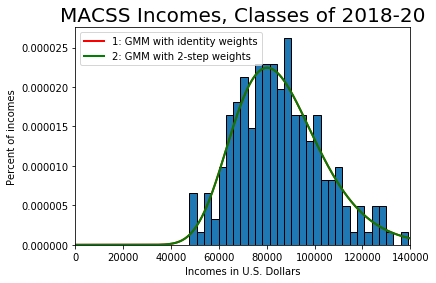

In [91]:
# Plot histogram with the estimated PDF
num_bins = 30
# normed option has been deprecated
# using density=True instead
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title("MACSS Incomes, Classes of 2018-20", fontsize=20)
plt.xlabel("Incomes in U.S. Dollars")
plt.ylabel("Percent of incomes")
plt.xlim([0,140000])


dist_pts = np.linspace(1e-10, 140000, 1000)
plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3),
         linewidth=2, color='r', label='1: GMM with identity weights')
plt.legend(loc='upper left')

plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_GMM2_3, sig_GMM2_3),
         linewidth=2, color='g', label='2: GMM with 2-step weights')
plt.legend(loc='upper left')


plt.show()

### Part f
We wish to determine which of the four estimations fits the data the best.  As we can see in our previous results, the estimated parameters are equal for all four of the estimations.  As such, the likelihood of observing the data given a set of parameters is equal across the four estimations.

For "best" we might appeal to the standard errors of the estimated parameters:

In [94]:
def Jac_err2(xvals, mu, sigma, simple=False):
    Jac_err = np.zeros((2, 2))
    h_mu = 1e-8 * mu
    h_sig = 1e-8 * sigma
    Jac_err[:, 0] = \
        ((err_vec(xvals, mu + h_mu, sigma, simple) -
          err_vec(xvals, mu - h_mu, sigma, simple)) / (2 * h_mu)).flatten()
    Jac_err[:, 1] = \
        ((err_vec(xvals, mu, sigma + h_sig, simple) -
          err_vec(xvals, mu, sigma - h_sig, simple)) / (2 * h_sig)).flatten()
    return Jac_err

In [95]:
def Jac_err3(xvals, mu, sigma, simple=False):
    Jac_err = np.zeros((3, 2))
    h_mu = 1e-8 * mu
    h_sig = 1e-8 * sigma
    Jac_err[:, 0] = \
        ((err_vec3(xvals, mu + h_mu, sigma, simple) -
          err_vec3(xvals, mu - h_mu, sigma, simple)) / (2 * h_mu)).flatten()
    Jac_err[:, 1] = \
        ((err_vec3(xvals, mu, sigma + h_sig, simple) -
          err_vec3(xvals, mu, sigma - h_sig, simple)) / (2 * h_sig)).flatten()
    return Jac_err

In [112]:
N = len(pts)
d_err1 = Jac_err2(pts, mu_GMM1, sig_GMM1, False)
SigHat1 = (1 / N) * lin.inv(d_err1.T @ W_hat1 @ d_err1)
print("For 2 moments and identity")
print('Std. err. mu_hat=', np.sqrt(SigHat1[0, 0]))
print('Std. err. sig_hat=', np.sqrt(SigHat1[1, 1]))

For 2 moments and identity
Std. err. mu_hat= 0.07373971821074995
Std. err. sig_hat= 0.016144777882961366


In [113]:
d_err2 = Jac_err2(pts, mu_GMM2, sig_GMM2, False)
SigHat2 = (1 / N) * lin.inv(d_err2.T @ W_hat2 @ d_err2)
print("For 2 moments and 2-step weights:")
print('Std. err. mu_hat=', np.sqrt(SigHat2[0, 0]))
print('Std. err. sig_hat=', np.sqrt(SigHat2[1, 1]))

For 2 moments and 2-step weights:
Std. err. mu_hat= 0.01501964103731327
Std. err. sig_hat= 0.009554897368788645


In [114]:
d_err1_3 = Jac_err3(pts, mu_GMM1_3, sig_GMM1_3, False)
SigHat1_3 = (1 / N) * lin.inv(d_err1_3.T @ W_hat1_3 @ d_err1_3)
print("For 3 moments and identity:")
print('Std. err. mu_hat=', np.sqrt(SigHat1_3[0, 0]))
print('Std. err. sigma_hat=', np.sqrt(SigHat1_3[1, 1]))

For 3 moments and identity:
Std. err. mu_hat= 0.009336424949022612
Std. err. sigma_hat= 0.006410643545058238


In [115]:
d_err2_3 = Jac_err3(pts, mu_GMM2_3, sig_GMM2_3, False)
SigHat2_3 = (1 / N) * lin.inv(d_err2_3.T @ W_hat2_3 @ d_err2_3)
print("For 3 moments and 2-step weights:")
print('Std. err. mu_hat=', np.sqrt(SigHat2_3[0, 0]))
print('Std. err. sigma_hat=', np.sqrt(SigHat2_3[1, 1]))

For 3 moments and 2-step weights:
Std. err. mu_hat= 0.0047887329650079915
Std. err. sigma_hat= 0.0017719704159597101


As we can see, each estimation gave us lower standard errors than before.  Thus, while each estimation produced identical point estimates of the parameters, the fourth technique, which used 3 moments and weights produced from the 2-step variance-covariance matrix, gave us the greatest power to reject null hypotheses.

## Problem 2
In this problem, we will be estimating the parameters of a linear regression model of the form
$$
sick_i = \beta_0 + \beta_1 * age_i + \beta_2 * children_i + \beta_3 * temp_winter_i + \varepsilon_i
$$

### Part a
We wish to estimate the parameters
$$
\beta_0, \beta_1, \beta_2, \beta_3
$$
through GMM by solving the minimization problem of the GMM criterion function.  We should use the identity matrix for the weights.  We should treat each observation of $sick_i$ as a data moment.  We should treat the predicted values as the model moments.

We should treat the error function of the moment be equal to the simple difference of the data moments from the model moments.



In [118]:
# Import the necessary libraries
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
#from mpl_toolkits.mplot3d import Axes3D
#from matplotlib import cm
#cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook

import requests
from IPython.display import Image

# Download and save the data file incomes.txt
url = ('https://raw.githubusercontent.com/dtracht/persp-model-econ_W19/' +
       'master/ProblemSets/PS5/data/sick.txt')
data_file = requests.get(url, allow_redirects=True)
open('data/sick.txt', 'wb').write(data_file.content)

# Load the data as a NumPy array
pts = np.genfromtxt("data/sick.txt", delimiter=",", skip_header=1)

In [121]:
def data_moments(points):
    y_obs = points[:,0]
    return y_obs

def model_moments(points, b0, b1, b2, b3):
    y_hats = b0 + b1*points[:,1] + b2*points[:,2] + b3*points[:,3]
    return y_hats

def err_vec(points, b0, b1, b2, b3):
    y_obs = data_moments(points)
    y_hats = model_moments(points, b0, b1, b2, b3)
    err_vec = y_obs - y_hats
    return err_vec

def criterion(params, *args):
    b0, b1, b2, b3 = params
    points, W = args
    err = err_vec(points, b0, b1, b2, b3)
    crit_val = err.T @ W @ err
    return crit_val

In [123]:
import scipy.optimize as opt

b0_init = 1
b1_init = 1
b2_init = 1
b3_init = 1

params_init = np.array([b0_init, b1_init, b2_init, b3_init])
W_hat1 = np.eye(len(pts[:,0]))
gmm_args = (pts, W_hat1)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14)
b0_GMM, b1_GMM, b2_GMM, b3_GMM= results.x
results
#print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

      fun: 0.0018212896917353956
 hess_inv: array([[ 0.05279912,  0.0004339 , -0.00904263, -0.00119901],
       [ 0.0004339 ,  0.00022671, -0.00202799, -0.00014215],
       [-0.00904263, -0.00202799,  0.02082409,  0.00128675],
       [-0.00119901, -0.00014215,  0.00128675,  0.0001096 ]])
      jac: array([-1.18244905e-04, -9.29031085e-05, -8.03606963e-05, -7.69579638e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 546
      nit: 9
     njev: 89
   status: 2
  success: False
        x: array([ 0.25164092,  0.01293345,  0.40050153, -0.00999163])

We wish examine the estimates for the parameters and the value of the GMM criterion function: